In [518]:
import numpy
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

#### Given Values

In [519]:
mechanical_eff = 0.99
gamma_air = 1.4
gamma_g = 1.33333
c_p_air = 1.005
c_p_gas = 1.148
R = 0.287

m_cool_vane_hpt = 0.1450776
m_cool_disc_hpt = 0.0797

# TURBINE INLET
T_01 = 1245.320         # [k]
P_01 = 1182.073         # [kPa]
m_dot_1 = 4.835922
M_1 = 0.125

# BETWEEN STATOR AND ROTOR
m_dot_2 = m_dot_1 + m_cool_vane_hpt

# TURBINE EXIT
T_03 = 1053.051
P_03 = 524.594
m_dot_3 = m_dot_2 + m_cool_disc_hpt

# BLADE PARAMETERS
# VANE
AR_vane = 0.5
TE_vane = 1.27/1000     # minimum trailing edge thickness in [m]
# BLADE
AR_rotor = 1.3
TE_rotor = 0.762/1000   # minimum trailing edge thickness in [m]
tip_clearance = 0.01    # minimum tip clearance span -> maximum is 0.02

## Define Ranges

Define the range for the stage loading coefficient, flow coefficient and the reaction. Using the obtained values, calculate the other values.

Use the following data:
1. Reaction ($\Lambda$) -> 0.35 - 0.65
2. Flow Coefficient ($\phi$) -> 0.6 - 1.0
3. Structural Limit ($AN^2$) -> 10000000 - 22580600 (checking for a wide range)
4. Zweifel for vane -> 0.75 - 0.90
5. Zweifel for rotor -> 0.80 - 0.95

In [520]:
range_degree_reaction = numpy.linspace(0.35, 0.65, 10)
range_stage_loading = numpy.linspace(3, 5, 10)
range_alpha_3 = numpy.linspace(10, 45, 10)
range_AN_squared = numpy.linspace(15000000, 22580600, 3)
range_zweifel_vane = numpy.linspace(0.75, 0.90, 15)
range_zweifel_rotor = numpy.linspace(0.80, 0.95, 15)
range_mach_exit = numpy.linspace(0.3, 0.55, 12)

### FUNCTIONS

In [521]:
class aeroturbine():

    def calc_properties(M, T_stagnation, P_stagnation):
        T = T_stagnation/(1 + ((gamma_g - 1)/2) * M**2)
        P = P_stagnation/((1 + ((gamma_g - 1)/2) * M**2))**(gamma_g/(gamma_g - 1))
        rho = P/(0.287*T)
        c = M * numpy.sqrt(gamma_g * 287 * T)

        return T, P, rho, c
    
    def calc_U(psi):
        """
        This function calculates the metal speed U.
        Input:  Stage loading coefficient "psi"
        Output: Returns the value of U
        """
        U = numpy.sqrt((2*c_p_gas*1000*(T_01 - T_03)) / (psi))    
        return U
    
    def calc_stage_3(U, alpha_3, C_3, T_3, rho_3):
    
        C_a_3 = C_3 * np.cos(np.radians(alpha_3))
        C_w_3 = np.sqrt(C_3**2 - C_a_3**2)
        V_w_3 = U + C_w_3
        V_3 = np.sqrt(V_w_3**2 + C_a_3**2)
        flow_coefficient_3 =  C_a_3 / U
        beta_3 = np.rad2deg(np.arctan(V_w_3 / C_a_3))
        a_3 = np.sqrt(gamma_g * R * 1000 * T_3)
        M_3_rel = V_3 / a_3
        A_3 = m_dot_3/(rho_3 * C_a_3)
        
        return C_a_3, C_w_3,  V_3, V_w_3, flow_coefficient_3, beta_3, a_3, M_3_rel, A_3
    
    def calc_stage_2(U, reaction, T_1, T_3, P_3, A_3, V_w_3):
        T_2 = T_3 + reaction * (T_1 - T_3)
        P_2 = P_3 * ((T_2/T_3) ** (gamma_g/(gamma_g - 1)))
        rho_2 = P_2 / (R * T_2)
        A_2 = A_3
        C_a_2 = m_dot_2/(rho_2 * A_2)
        flow_coefficient_2 = C_a_2 / U
        a_2 = np.sqrt(gamma_g * R * 1000 * T_2)
        V_w_2 = V_w_3 - (2*reaction * U)
        beta_2 = np.rad2deg(np.arctan(V_w_2 / C_a_2))
        V_2 = np.sqrt(V_w_2**2 + C_a_2**2)
        C_w_2 = V_w_2 + U
        C_2 = np.sqrt(C_w_2**2 + C_a_2**2)
        alpha_2 = np.rad2deg(np.arctan(C_w_2/C_a_2))
        M_2 = C_2 / a_2
        M_2_rel = V_2 / a_2

        return T_2, P_2, rho_2, A_2, C_a_2, flow_coefficient_2, a_2, V_w_2, beta_2, V_2, C_w_2, C_2, alpha_2, M_2, M_2_rel
    
    def calc_hub_angles(r_m_pointer, r_hub_pointer, alpha_2_pointer, alpha_3_pointer, flow_coeff_2_pointer, flow_coeff_3_pointer, U_pointer, C_a_2, a_2):
        alpha_2_hub_rad = numpy.arctan((r_m_pointer/r_hub_pointer) *numpy.tan(numpy.deg2rad(alpha_2_pointer)))
        alpha_2_hub_deg = numpy.rad2deg(alpha_2_hub_rad)
    
        alpha_3_hub_rad = numpy.arctan((r_m_pointer/r_hub_pointer) *numpy.tan(numpy.deg2rad(alpha_3_pointer)))
        alpha_3_hub_deg = numpy.rad2deg(alpha_3_hub_rad)
    
        beta_2_hub_rad = numpy.arctan((r_m_pointer/r_hub_pointer) *numpy.tan(numpy.deg2rad(alpha_2_pointer)) - (r_hub_pointer/r_m_pointer)*(flow_coeff_2_pointer)**(-1))
        beta_2_hub_deg = numpy.rad2deg(beta_2_hub_rad)
    
        beta_3_hub_rad = numpy.arctan((r_m_pointer/r_hub_pointer) *numpy.tan(numpy.deg2rad(alpha_3_pointer)) + (r_hub_pointer/r_m_pointer)*(flow_coeff_3_pointer)**(-1))
        beta_3_hub_deg = numpy.rad2deg(beta_3_hub_rad)

        U_hub = U_pointer * (r_hub_pointer / r_m_pointer)

        V_2_hub = C_a_2/np.cos(beta_2_hub_rad)
        C_2_hub = C_a_2/np.cos(alpha_2_hub_rad)

        M_2_rel_hub = V_2_hub / a_2
        M_2_hub = C_2_hub / a_2

        return alpha_2_hub_deg, alpha_3_hub_deg, beta_2_hub_deg, beta_3_hub_deg,  U_hub, V_2_hub, C_2_hub, M_2_rel_hub, M_2_hub
    
    

    def calc_tip_angles(r_m_pointer, r_tip_pointer, alpha_2_pointer, alpha_3_pointer, flow_coeff_2_pointer, flow_coeff_3_pointer, U_pointer, C_a_2, a_2):
            alpha_2_tip_rad = numpy.arctan((r_m_pointer/r_tip_pointer) *numpy.tan(numpy.deg2rad(alpha_2_pointer)))
            alpha_2_tip_deg = numpy.rad2deg(alpha_2_tip_rad)
        
            alpha_3_tip_rad = numpy.arctan((r_m_pointer/r_tip_pointer) *numpy.tan(numpy.deg2rad(alpha_3_pointer)))
            alpha_3_tip_deg = numpy.rad2deg(alpha_3_tip_rad)
        
            beta_2_tip_rad = numpy.arctan((r_m_pointer/r_tip_pointer) *numpy.tan(numpy.deg2rad(alpha_2_pointer)) - (r_tip_pointer/r_m_pointer)*(flow_coeff_2_pointer)**(-1))
            beta_2_tip_deg = numpy.rad2deg(beta_2_tip_rad)
        
            beta_3_tip_rad = numpy.arctan((r_m_pointer/r_tip_pointer) *numpy.tan(numpy.deg2rad(alpha_3_pointer)) + (r_tip_pointer/r_m_pointer)*(flow_coeff_3_pointer)**(-1))
            beta_3_tip_deg = numpy.rad2deg(beta_3_tip_rad)    

            U_tip = U_pointer * (r_tip_pointer / r_m_pointer)
            V_2_tip = C_a_2/np.cos(beta_2_tip_rad)
            C_2_tip = C_a_2/np.cos(alpha_2_tip_rad)

            M_2_rel_tip = V_2_tip / a_2
            M_2_tip = C_2_tip / a_2


            return alpha_2_tip_deg, alpha_3_tip_deg, beta_2_tip_deg, beta_3_tip_deg, U_tip, V_2_tip, C_2_tip, M_2_rel_tip, M_2_tip
    

    def calc_tip_hub_reaction(c_a_3_pointer, c_a_2_pointer ,beta_2_hub, beta_2_tip, beta_3_hub, beta_3_tip, U_hub, U_tip):

            reaction_hub = (c_a_3_pointer * numpy.tan(numpy.deg2rad(beta_3_hub)) - c_a_2_pointer*numpy.tan(numpy.deg2rad(beta_2_hub)))/(2*U_hub)
            reaction_tip = (c_a_3_pointer * numpy.tan(numpy.deg2rad(beta_3_tip)) - c_a_2_pointer*numpy.tan(numpy.deg2rad(beta_2_tip)))/(2*U_tip)

            return reaction_hub, reaction_tip

In [522]:
class aerostructural():
    def calc_structural(an_squared_pointer, area_2_pointer, U_meanline_pointer):
        N = numpy.sqrt((an_squared_pointer)/area_2_pointer)
        omega = N*2*numpy.pi/60
        r_meanline = U_meanline_pointer/omega
        h = (area_2_pointer * (N/60))/U_meanline_pointer
        r_hub = r_meanline - (h/2)
        r_tip = r_meanline + (h/2)
        return N, omega, r_hub, r_tip, r_meanline, h


## Aerodynamic Losses

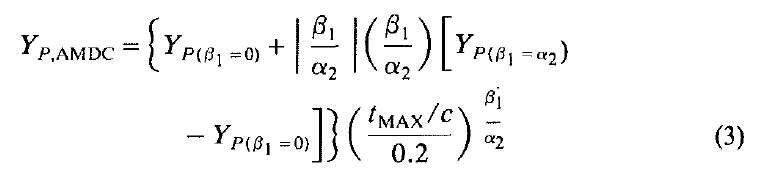

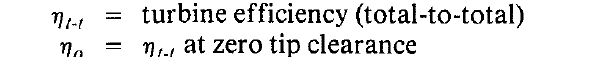

In [523]:
class aerodynamic_losses():
    """
    Profile losses calculated in this class.
    """
    class profile_losses():
        """
        Profile losses calculated in this class.
        """
        def figure_2_3a(pitch_chord_ratio, exit_flow_angle):
            fig_2_3a = pd.read_csv(r'_input_database\figure_2_3a.csv')
            X = fig_2_3a[['pitch_chord_ratio', 'exit_flow_angle']]
            y = fig_2_3a['K_P_1']

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            model = LinearRegression()
            model.fit(X_train, y_train)

            X = pd.DataFrame({'pitch_chord_ratio': [pitch_chord_ratio], 'exit_flow_angle': [exit_flow_angle]})
            K_P_1 = model.predict(X)
            
            return K_P_1[0]
    
        def figure_2_3b(pitch_chord_ratio, exit_flow_angle):
            fig_2_3b = pd.read_csv(r'_input_database\figure_2_3b.csv')
            X = fig_2_3b[['pitch_chord_ratio', 'exit_flow_angle']]
            y = fig_2_3b['K_P_2']

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            model = LinearRegression()
            model.fit(X_train, y_train)

            X = pd.DataFrame({'pitch_chord_ratio': [pitch_chord_ratio], 'exit_flow_angle': [exit_flow_angle]})
            K_P_2 = model.predict(X)
            
            return K_P_2[0]
         
        def figure_2_4(beta_b1, beta_b2):
            beta_eff = beta_b1 + beta_b2
            fig_2_4 = pd.read_csv(r'_input_database\figure_2_4.csv')
            X = fig_2_4[['beta_b1_b2']]
            y = fig_2_4['tmax_and_c']

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            model = LinearRegression()
            model.fit(X_train, y_train)

            X = pd.DataFrame({'beta_b1_b2': [beta_eff]})
            tmax_and_c = model.predict(X)
            
            return tmax_and_c[0]
        
        def figure_2_5(beta_b1, beta_b2):
            fig_2_5 = pd.read_csv(r'_input_database\figure_2_5.csv')
            X = fig_2_5[['beta_b1', 'beta_b2']]
            y = fig_2_5['Stagger Angle']

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            model = LinearRegression()
            model.fit(X_train, y_train)

            X = pd.DataFrame({'beta_b1': [beta_b1], 'beta_b2': [beta_b2]})
            stagger_angle = model.predict(X)
            
            return stagger_angle[0]
        
        
        def figure_2_6(x_value, x=True):
            """
            x = True for Rotor
            """
            fig_2_6 = pd.read_csv(r'_input_database\figure_2_6.csv')
            rhrt = fig_2_6['x'].values
            y1 = fig_2_6['Rotor'].values
            y2 = fig_2_6['Nozzle'].values

            if x == True:
                interp_func = interp1d(rhrt, y1, kind='cubic')
                interpolated_y = interp_func(x_value)
            else:
                interp_func = interp1d(rhrt, y2, kind='cubic')
                interpolated_y = interp_func(x_value)
            
            return interpolated_y

        def figure_2_7(x_value):

            fig_2_7 = pd.read_csv(r'_input_database\figure_2_7.csv')
            x = fig_2_7['M_1_hub'].values
            y = fig_2_7['delta_p_q_1_hub'].values

            interp_func = interp1d(x, y, kind='cubic')
            interpolated_y = interp_func(x_value)
            
            return interpolated_y


        """
        The following section give information about the symbols to be used for the following class.
        This is established from the information provided in Axial and Radial Turbines Part A - Moustapha.
        """
        def calc_K_p(M_1, M_2, M_1_rel_hub, P_1, P_2 ,r_tip, r_hub, beta_in, beta_out, zweifel_pointer):
            """
            Using corrected effects of exit mach number.
            Function used to determine K_accel.
            Equation (2.7), (2.8)
            IMPORTANT:
            FOR STATOR
            beta_in -> alpha_1
            beta_out -> alpha_2
            FOR ROTOR
            beta_in -> beta_2
            beta_out -> beta_3

            """
            #  ============= K_p_star =============
            # get the stagger angle from figure 2.5
            stagger_angle = aerodynamic_losses.profile_losses.figure_2_5(beta_in, beta_out)      # [deg]
            tmax_and_c = aerodynamic_losses.profile_losses.figure_2_4(beta_in, beta_out)

            pitch_chord_ratio = (zweifel_pointer / (2 * (numpy.tan(numpy.radians(beta_in)) + numpy.tan(numpy.radians(beta_out)) ) * (numpy.cos(numpy.radians(beta_out)))**2))  * numpy.cos(numpy.radians(stagger_angle))
            pitch_axial_chord_ratio = pitch_chord_ratio/numpy.cos(numpy.radians(stagger_angle))
            K_P_2 = aerodynamic_losses.profile_losses.figure_2_3b(pitch_chord_ratio, beta_out)         # beta_3 in other code
            K_P_1 = aerodynamic_losses.profile_losses.figure_2_3a(pitch_chord_ratio, beta_out)         # beta_3 in other code
            K_p_star = (K_P_1 + (abs(beta_in / beta_out) * (beta_in / beta_out))*(K_P_2 - K_P_1)) * ((tmax_and_c / 0.2)**(beta_in / beta_out))
            #  =============== K_sh ===============
            k = 1.333333

            if M_1_rel_hub <= 0.4:
                A = 0
            if M_1_rel_hub > 0.4:      
                A = 0.75 * ((M_1_rel_hub - 0.4)**(7/4))

            B = A * (r_hub/r_tip)
            C = 1 - ((1 + ((k - 1) / (2)) * M_1**2)**(k/(k - 1)))
            D = 1 - ((1 + ((k - 1) / (2)) * M_2**2)**(k/(k - 1)))

            K_sh = B * (P_1 / P_2) * (C / D)

            #  ============== K_accel ==============
            if M_2 <= 0.2:
                K_1 = 1.0
            if M_2 > 0.2:
                K_1 = 1 - 1.25 * (M_2 - 0.2)
            K_2 = (M_1/M_2)**2
            K_accel = 1 - K_2 * (1 - K_1)

            #  ================ K_p ================
            K_p = 0.914 * ((2/3) * K_p_star * K_accel + K_sh)

            return K_p, pitch_chord_ratio, K_accel, stagger_angle,  pitch_chord_ratio
        
    class secondary_losses():

        def calc_K_s(K_accel, AR, beta_in, beta_out):
            """
            FOR STATOR
            beta_in -> alpha_1
            beta_out -> alpha_2
            FOR ROTOR
            beta_in -> beta_2
            beta_out -> beta_3
            """

            if AR <= 2:
                f_AS = (1- 0.25 * np.sqrt(2 - AR))/(AR)
            if AR > 2:
                f_AS = 1/AR           
            alpha_m = np.arctan(0.5 * (np.tan(np.radians(beta_in)) - np.tan(np.radians(beta_out)))) 
            A = np.cos(np.radians(beta_out))/np.cos(np.radians(beta_in))  
            B = 2 * (np.tan(np.radians(beta_in)) + np.tan(np.radians(beta_out))) * np.cos(alpha_m)  
            C = ((np.cos(np.radians(beta_out)))**2) / ((np.cos(alpha_m))**3)   
            K_s_star = 0.0334 * f_AS * A *  (B**2) * C
            K_3 = 1 / ((AR)**2)
            K_cs = 1 - K_3 * (1 - K_accel)
            K_s = 1.2 * K_s_star * K_cs

            return K_s
        
    class trailing_edge_losses():

        def figure_2_10(x_value, beta_in, beta_out):
            """
            f -> delta_phi_squared_TE
            FOR STATOR
            beta_in -> alpha_1
            beta_out -> alpha_2
            FOR ROTOR
            beta_in -> beta_2
            beta_out -> beta_3
            """
            fig_2_10 = pd.read_csv(r'_input_database\figure_2_10.csv')
            r_te_o = fig_2_10['r_te_o'].values
            impulse_blading = fig_2_10['impulse_blading'].values
            stator_vanes = fig_2_10['stator_vanes'].values

            interp_func_1 = interp1d(r_te_o, impulse_blading, kind='cubic')
            interp_func_2 = interp1d(r_te_o, stator_vanes, kind='cubic')
            f_alpha  = interp_func_1(x_value)
            f_zero = interp_func_2(x_value)

            f = f_zero + (abs(beta_in / beta_out) * (beta_in / beta_out))*(f_alpha - f_zero)

            return f

        def K_TET(o, M_2, beta_in, beta_out):
            """
            M_2 -> Use relative M_2_rel for the rotor.
            FOR STATOR
            beta_in -> alpha_1
            beta_out -> alpha_2
            FOR ROTOR
            beta_in -> beta_2
            beta_out -> beta_3
            """
            r_to_o = TE_rotor/o
            f = aerodynamic_losses.trailing_edge_losses.figure_2_10(r_to_o ,beta_in, beta_out)
            
            term1 = ((gamma_g - 1) / 2) * M_2**2
            term2 = (1 / (1 - f)) - 1
            numerator = ((1 - term1 * (term2))**(-gamma_g / (gamma_g - 1)) )- 1
            denominator = 1 - ((1 + term1))**(-gamma_g / (gamma_g - 1))
            K_TE = numerator / denominator
            
            return K_TE, r_to_o, f
        
    class clearance_losses():

        def K_clr(h):
            pass



#### Temperature and Pressure Calculations
From part A cycle calculations.

Turbine Station 1 -> INLET
Turbine Station 2 -> BETWEEN ROTOR AND STATOR


1. C -> Absolute Velocity 
2. V -> Relative Velocity 
3. C_a -> Axial Velocity 
4. M_1 -> Absolute Mach Number
5. M_1_rel -> Relative Mach Number

**NOTE** -> For 0 incidence -> $\alpha_1 = \alpha_{b1}$ is the value for $\beta_2$ for us.

## True Stories

In [524]:
data = []

for i in range_mach_exit:
    for j in range_stage_loading:
        for k in range_alpha_3:
            for l in range_degree_reaction:
                for m in range_AN_squared:
                    #for n in range_zweifel_vane:
                    T_1, P_1, rho_1, C_1 = aeroturbine.calc_properties(M_1, T_01, P_01)
                    C_a_1 = C_1 * np.cos(np.radians(-10))
                    T_3, P_3, rho_3, C_3 = aeroturbine.calc_properties(i, T_03, P_03)

                    # Calculate U from the stage loading.
                    U = aeroturbine.calc_U(j)
                    C_a_3, C_w_3,  V_3, V_w_3, flow_coefficient_3, beta_3, a_3, M_3_rel, A_3 = aeroturbine.calc_stage_3(U, k, C_3, T_3, rho_3)
                    T_2, P_2, rho_2, A_2, C_a_2, flow_coefficient_2, a_2, V_w_2, beta_2, V_2, C_w_2, C_2, alpha_2, M_2, M_2_rel = aeroturbine.calc_stage_2(U, l, T_1, T_3, P_3, A_3, V_w_3)
                    
                    A_1 = m_dot_1/(rho_1 * C_a_1)
                    N, omega, r_hub, r_tip, r_meanline, h = aerostructural.calc_structural(m, A_2, U)

                    alpha_2_hub, alpha_3_hub, beta_2_hub, beta_3_hub, U_hub, V_2_hub, C_2_hub, M_2_rel_hub, M_2_hub = aeroturbine.calc_hub_angles(r_meanline, r_hub, alpha_2, k, flow_coefficient_2, flow_coefficient_3, U, C_a_2, a_2)
                    alpha_2_tip, alpha_3_tip, beta_2_tip, beta_3_tip, U_tip, V_2_tip, C_2_tip, M_2_rel_tip, M_2_tip = aeroturbine.calc_tip_angles(r_meanline, r_tip, alpha_2, k, flow_coefficient_2, flow_coefficient_3, U, C_a_2, a_2)
                    reaction_hub, reaction_tip = aeroturbine.calc_tip_hub_reaction(C_a_3, C_a_2 ,beta_2_hub, beta_2_tip, beta_3_hub, beta_3_tip, U_hub, U_tip)   

                    if V_3 > V_2 and C_2 > C_1 and rho_3 < rho_2 < rho_1: # Velocity check and density check _>
                        # Other value checks from the design requirements _>
                        if 144 <= C_3 <= 339 and 190 <= C_a_3 <= 202 and 40 <= alpha_2 <= 75 and reaction_hub > 0 and M_2_rel_hub > M_2_rel_tip:
                            if 0 < alpha_2_tip < alpha_2 < alpha_2_hub and 0 < beta_2_tip < beta_2 < beta_2_hub and 0 < alpha_3_tip < k < alpha_3_hub and beta_3_tip > beta_3 > beta_3_hub > 0:

                                # CALCULATE LOSSES
                                K_p, pitch_chord_ratio, K_accel, stagger_angle, pitch_axial_chord_ratio =  aerodynamic_losses.profile_losses.calc_K_p(M_2_rel, M_3_rel, M_2_rel_hub, P_2, P_3, r_tip, r_hub,  beta_2, beta_3, 0.80)

                                # Calculations for throat opening
                                c_true = (h)/AR_rotor
                                c_a = (h * np.cos(np.radians(stagger_angle)))/AR_rotor
                                N_rotor = math.floor((2 * np.pi * r_meanline) /(pitch_axial_chord_ratio * c_a))
                                o_rotor = (pitch_axial_chord_ratio * c_a) * np.sin(np.radians(beta_3))
                                K_s = aerodynamic_losses.secondary_losses.calc_K_s(K_accel, AR_rotor, beta_2, beta_3)
                                K_TET, r_to_o, f = aerodynamic_losses.trailing_edge_losses.K_TET(o_rotor, M_2_rel, beta_2, beta_3)
                                K = K_p + K_s + K_TET
                                
                                data.append((j, l, T_1, P_1, rho_1, A_1, C_1, C_a_1, i, T_3, P_3, rho_3, C_3, k, U,
                                            C_a_3, C_w_3,  V_3, V_w_3, flow_coefficient_3, beta_3, a_3, M_3_rel, A_3,
                                            T_2, P_2, rho_2, A_2, C_a_2, flow_coefficient_2, a_2, V_w_2, beta_2, V_2, C_w_2, C_2, alpha_2, M_2, M_2_rel,
                                            N, omega, r_hub, r_tip, r_meanline, h,
                                            alpha_2_hub, alpha_3_hub, beta_2_hub, beta_3_hub, U_hub, V_2_hub, C_2_hub, M_2_rel_hub, M_2_hub,
                                            alpha_2_tip, alpha_3_tip, beta_2_tip, beta_3_tip, U_tip, V_2_tip, C_2_tip, M_2_rel_tip, M_2_tip,
                                            reaction_hub, reaction_tip, N_rotor,
                                            K_p,  pitch_chord_ratio, K_accel, o_rotor,c_a,c_true,
                                            K_s, K_TET,r_to_o, f ,
                                            K))

                    else:
                        print("Check your code!!")
                        break


df = pd.DataFrame(data, columns = ['stage_loading','reaction_mean','T_1', 'P_1', 'rho_1', 'A_1','C_1', 'C_a_1','M_3','T_3','P_3', 'rho_3', 'C_3', 'alpha_3','U',
                                   'C_a_3', 'C_w_3',  'V_3', 'V_w_3', 'flow_coefficient_3', 'beta_3', 'a_3', 'M_3_rel', 'A_3',
                                   'T_2', 'P_2', 'rho_2', 'A_2', 'C_a_2', 'flow_coefficient_2', 'a_2', 'V_w_2', 'beta_2', 'V_2', 'C_w_2', 'C_2', 'alpha_2', 'M_2', 'M_2_rel',
                                   'N', 'omega', 'r_hub', 'r_tip', 'r_meanline', 'h',
                                   'alpha_2_hub', 'alpha_3_hub', 'beta_2_hub', 'beta_3_hub', 'U_hub', 'V_3_hub', 'C_2_hub', 'M_2_rel_hub', 'M_2_hub',
                                   'alpha_2_tip', 'alpha_3_tip', 'beta_2_tip', 'beta_3_tip', 'U_tip', 'V_3_tip', 'C_2_tip', 'M_2_rel_tip', 'M_2_tip',
                                   'reaction_hub', 'reaction_tip', 'N_rotor',
                                   'K_p',  'pitch_chord_ratio', 'K_accel', 'o_rotor', 'c_a', 'c_true',
                                   'K_s', 'K_TET', 'r_to_o', 'f' ,
                                   'K'])

## Loss Calculations

1. In the calculations for pitch to chord ratio -> use beta values -> exit flow angle.
2. for stagger angle and $t_{max} / c$ -> use beta values.

Write results to file

In [525]:
df.to_csv('_outputs/output.csv', index=False)